# **LANGUAGE-IDENTIFICATION CLASSIFFICATION HACKATHON**

**Overview**

South Africa is a multicultural society that is characterised by its rich linguistic diversity. Language is an indispensable tool that can be used to deepen democracy and also contribute to the social, cultural, intellectual, economic and political life of the South African society.

The country is multilingual with 11 official languages, each of which is guaranteed equal status. Most South Africans are multilingual and able to speak at least two or more of the official languages.
From South African Government

With such a multilingual population, it is only obvious that our systems and devices also communicate in multi-languages.

**AIM**

Is to take text which is in any of South Africa's 11 Official languages and predict which language the text is in, using NLP.

## TABLE OF CONTENTS
1. Importing Libraries
2. Loading of data sets
3. Exploratory Data Analysis
4. Preprocessing/ Cleaning of Data
5. Training and Evaluation of the models
6. Model Comparison
7. Submission
8. Conclusion

### Import  Libraries

In [1]:
# imports for Natural Language  Processing
import pandas as pd
import numpy as np
import nltk
import string
import seaborn as sns
import re
from sklearn.pipeline import Pipeline
from nltk.tokenize import sent_tokenize


# feature extractioin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Preprocessing
from collections import Counter
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split

# classification models
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB


# Hyperparameter tunning methods
from sklearn.model_selection import GridSearchCV

# metrics

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt

%matplotlib inline

# Warnings

import warnings
warnings.filterwarnings("ignore")
#Setting Plot figure size
sns.set(rc={'figure.figsize':(12.8,11.27)})

## Load and view data sets

In [2]:
train = pd.read_csv("train_set.csv")
test = pd.read_csv("test_set.csv")

In [3]:
#create a copy of the data
df_train = train.copy()
df_test = test.copy()

In [4]:
df_train.head()

,lang_id,text
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko ax...
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...
2,eng,the province of kwazulu-natal department of tr...
3,nso,o netefatša gore o ba file dilo ka moka tše le...
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...


In [5]:
df_test.head()

,index,text
0,1,"Mmasepala, fa maemo a a kgethegileng a letlele..."
1,2,Uzakwaziswa ngokufaneleko nakungafuneka eminye...
2,3,Tshivhumbeo tshi fana na ngano dza vhathu.
3,4,Kube inja nelikati betingevakala kutsi titsini...
4,5,Winste op buitelandse valuta.


### EDA

In [6]:
df_train.describe()

,lang_id,text
count,33000,33000
unique,11,29948
top,xho,ngokwesekhtjheni yomthetho ophathelene nalokhu...
freq,3000,17


#### Train Information

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33000 entries, 0 to 32999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   lang_id  33000 non-null  object
 1   text     33000 non-null  object
dtypes: object(2)
memory usage: 515.8+ KB


The train dataset has 33000 entries, 2 columns (lang_id, text), doesn't have any missing values and one data type which is an 'object'

#### Value Count

In [8]:
df_train['lang_id'].value_counts()

xho    3000
eng    3000
nso    3000
ven    3000
tsn    3000
nbl    3000
zul    3000
ssw    3000
tso    3000
sot    3000
afr    3000
Name: lang_id, dtype: int64

All the languages have equal number of entries which means our data is balanced.

#### Unique values

In [9]:
df_train['lang_id'].unique()

array(['xho', 'eng', 'nso', 'ven', 'tsn', 'nbl', 'zul', 'ssw', 'tso',
       'sot', 'afr'], dtype=object)

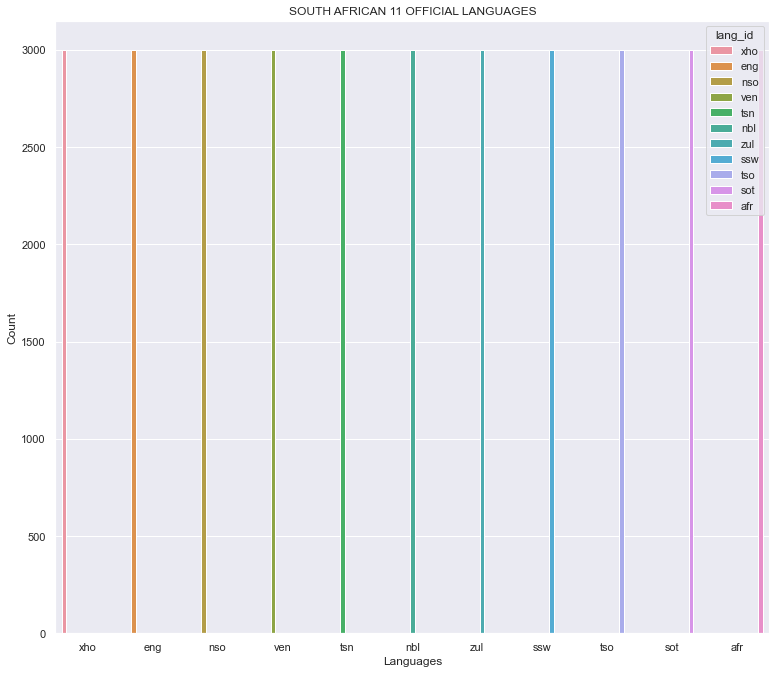

In [10]:
sns.countplot(x="lang_id", hue="lang_id",data=df_train,
              order=df_train.lang_id.value_counts().iloc[:20].index) 
plt.ylabel('Count')
plt.xlabel('Languages')
plt.title('SOUTH AFRICAN 11 OFFICIAL LANGUAGES')
plt.show()

We are dealing with balanced data set meaning the model(s) will be trained properly.


## Preprocessing

#### LowerCase 

First convert all text data into lowercase

In [11]:
# Lower case all words to remove noise from Capital words. Capital words may be seen as different from lower case words
df_train['text'] = df_train['text'].str.lower()
df_test['text'] = df_test['text'].str.lower()

#### Remove punctuations

In [12]:
def removing_punctuations(data):
    """This function take a string/list as an input and removes all the punctuations"""

    words = str.maketrans('', '', string.punctuation)
    return data.translate(words)  
df_train['text'] = df_train['text'].apply(lambda x: removing_punctuations(x))
df_test['text'] = df_test['text'].apply(lambda x: removing_punctuations(x))

#### Clean the data

In [13]:
def removing_URL(data):
    return re.sub(r"http\S+", "", data) 
def removing_repeating_char(data):
    return re.sub(r'(.)1+', r'1', data)
def removing_numbers(data):
    return re.sub('[0-9]+', '', data)
def remove_other(data):
    
    data = re.sub('\[.*?\]', '', data)
    data = re.sub('<.*?>+', '', data)
    data = re.sub('[%s]' % re.escape(string.punctuation), '', data)
    data = re.sub('\n', '', data)
    data = re.sub('\w*\d\w*', '', data)
    
    return data
def clean_data(tokenized_text):
    """Clean each word from list of tokenized text"""
    tokenized_text = removing_URL(tokenized_text)
    tokenized_text = removing_repeating_char(tokenized_text)
    tokenized_text = removing_numbers(tokenized_text)
    tokenized_text = remove_other(tokenized_text)
    return tokenized_text

In [14]:
df_train['text'] = df_train['text'].apply(lambda x: clean_data(x))
df_test['text'] = df_test['text'].apply(lambda x: clean_data(x))

In [15]:
df_train.head(10)

,lang_id,text
0,xho,umgaqosiseko wenza amalungiselelo kumaziko axh...
1,xho,idha iya kuba nobulumko bokubeka umsebenzi nap...
2,eng,the province of kwazulunatal department of tra...
3,nso,o netefatša gore o ba file dilo ka moka tše le...
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...
5,nso,dinyakišišo tše tša go dirwa gabedi ka ngwaga ...
6,tsn,kgetse nngwe le nngwe e e sa faposiwang mo tsh...
7,ven,mbadelo dze dza laelwa dzi do kwama mahatulele...
8,nso,maloko a dikhuduthamaga a ikarabela mongwe le ...
9,tsn,fa le dirisiwa lebone le tshwanetse go bontsha...


## Splitting the Data

In [16]:
# Set the X and y variables to contain the feature ('text' column) and label ('lang_id' column), respectively.
X = train['text']
y = train['lang_id']

In [17]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Size of training set:", X_train.shape)
print("Size of test set:", X_test.shape)

Size of training set: (26400,)
Size of test set: (6600,)


## Training and Evaluation

### Logistic Regression

In [18]:
# Create pipeline for Logistic Regression:
LR = Pipeline([('tfidf', TfidfVectorizer()),('lr', LogisticRegression()),])

# Model Generation Using Logitic Regression
LR.fit(X_train, y_train)
pred_lr = LR.predict(X_test)

# Classification report
print(classification_report(y_test, pred_lr))
LR_metrics = classification_report(y_test, pred_lr)

# Use accuracy_score function to get the accuracy
LR_Acc = round(accuracy_score(pred_lr, y_test)*100, 2)
print("Logistic Regression Accuracy Score: ", LR_Acc)
LR_F1 = round(f1_score(pred_lr, y_test, average="macro")*100, 2)
print("F1 Score: ",LR_F1 )

              precision    recall  f1-score   support

         afr       1.00      0.99      0.99       583
         eng       1.00      1.00      1.00       615
         nbl       0.98      0.99      0.99       583
         nso       1.00      0.99      1.00       625
         sot       1.00      1.00      1.00       618
         ssw       0.99      1.00      0.99       584
         tsn       1.00      1.00      1.00       598
         tso       1.00      1.00      1.00       561
         ven       1.00      1.00      1.00       634
         xho       0.99      1.00      0.99       609
         zul       0.98      0.98      0.98       590

    accuracy                           0.99      6600
   macro avg       0.99      0.99      0.99      6600
weighted avg       0.99      0.99      0.99      6600

Logistic Regression Accuracy Score:  99.47
F1 Score:  99.46


### Linear Support Vector Classifier

In [19]:
# Create pipeline for Linear SVC:
LSVC = Pipeline([('LSVC_tfidf', TfidfVectorizer()),('LSVC_clf', LinearSVC())])

# Model Generation Using Linear SVC
LSVC.fit(X_train, y_train)
pred_LSVC = LSVC.predict(X_test)

# Classification report
print(classification_report(y_test, pred_LSVC))
LSVC_metrics = classification_report(y_test, pred_LSVC)

# Use accuracy_score function to get the accuracy
LSVC_Acc = round(accuracy_score(pred_LSVC, y_test)*100, 2)
print("Linear SVC Accuracy Score: ",LSVC_Acc)
LSVC_F1 = round(f1_score(pred_LSVC, y_test, average="macro")*100, 2)
print("F1 Score: ", LSVC_F1)

              precision    recall  f1-score   support

         afr       1.00      1.00      1.00       583
         eng       1.00      1.00      1.00       615
         nbl       0.99      0.99      0.99       583
         nso       1.00      1.00      1.00       625
         sot       1.00      1.00      1.00       618
         ssw       1.00      1.00      1.00       584
         tsn       1.00      1.00      1.00       598
         tso       1.00      1.00      1.00       561
         ven       1.00      1.00      1.00       634
         xho       1.00      1.00      1.00       609
         zul       0.99      0.99      0.99       590

    accuracy                           1.00      6600
   macro avg       1.00      1.00      1.00      6600
weighted avg       1.00      1.00      1.00      6600

Linear SVC Accuracy Score:  99.71
F1 Score:  99.71


### Naive Bayes Multinomial

In [20]:
# Create pipeline for Naive Bayes Multinomial
NBM = Pipeline([('tfidf_CLF', TfidfVectorizer()),('NBM_CLF', MultinomialNB()),])

# Model Generation Using Naive Bayes Multinomial
NBM.fit(X_train, y_train)
pred_NBM = NBM.predict(X_test)

# Classification report
print(classification_report(y_test, pred_NBM))
NBM_metrics = classification_report(y_test, pred_NBM)

# Use accuracy_score function to get the accuracy
NBM_Acc = round(accuracy_score(pred_NBM, y_test)*100, 2)
print("Naive Bayes Accuracy Score: ",NBM_Acc)
NBM_F1 = round(f1_score(pred_NBM, y_test, average="macro")*100, 2)
print("F1 Score: ",NBM_F1 )

              precision    recall  f1-score   support

         afr       1.00      1.00      1.00       583
         eng       1.00      1.00      1.00       615
         nbl       0.99      1.00      0.99       583
         nso       1.00      1.00      1.00       625
         sot       1.00      1.00      1.00       618
         ssw       1.00      1.00      1.00       584
         tsn       1.00      1.00      1.00       598
         tso       1.00      1.00      1.00       561
         ven       1.00      1.00      1.00       634
         xho       1.00      1.00      1.00       609
         zul       1.00      0.99      0.99       590

    accuracy                           1.00      6600
   macro avg       1.00      1.00      1.00      6600
weighted avg       1.00      1.00      1.00      6600

Naive Bayes Accuracy Score:  99.8
F1 Score:  99.8


The best perfoming model is Naive Bayes Multimonial out of all the models I trained, so I will hyper-parameter tune it to improve the model performace.

### Hyperparameter Optimization

Steps to tune the parameters:

- Prioritize those parameters which have the most effect on our model. (Example: n-neighbors bor KNN, n-estimators for random forest etc.)
- Set various values to these parameters and store them in a dictionary as shown below.
- Create an object of the GridSearchCV class and assign the parameters to it.
- Fit the training set in the object.
- Use this object to fit training set to your classifier.

### Grid Search

In [21]:
MultinomialNB().get_params()

{'alpha': 1.0, 'class_prior': None, 'fit_prior': True}

In [22]:
# Setting parameter grid
param_grid = {'alpha': [0.01, 0.10 , 1]}  

HP_NBM = Pipeline([('tfidf', TfidfVectorizer(min_df=2,
                                                max_df=0.5,
                                                ngram_range=(6, 6), 
                                                analyzer = 'char')),
                      ('HP_NBM', GridSearchCV(MultinomialNB(),
                                           param_grid=param_grid,
                                           cv=5,
                                           n_jobs=-1))
                      ])
# Model Generation Using Hyper tuned Naive Bayes Multinomial 
HP_NBM.fit(X_train, y_train)  
pred_HP_NBM = HP_NBM.predict(X_test) 

# Classification Report
print(classification_report(y_test, pred_HP_NBM))
HP_NBM_metrics = classification_report(y_test, pred_HP_NBM)

# Use accuracy_score function to get the accuracy
HP_NBM_Acc = round(accuracy_score(pred_HP_NBM, y_test)*100, 2)
print("Hyper parameter tuned Naive Bayes Accuracy Score: ", HP_NBM_Acc)
HP_NBM_F1 = round(f1_score(pred_HP_NBM, y_test, average="macro")*100, 2)
print("F1 Score: ",HP_NBM_F1)

              precision    recall  f1-score   support

         afr       1.00      1.00      1.00       583
         eng       1.00      1.00      1.00       615
         nbl       1.00      1.00      1.00       583
         nso       1.00      1.00      1.00       625
         sot       1.00      1.00      1.00       618
         ssw       1.00      1.00      1.00       584
         tsn       1.00      1.00      1.00       598
         tso       1.00      1.00      1.00       561
         ven       1.00      1.00      1.00       634
         xho       1.00      1.00      1.00       609
         zul       1.00      1.00      1.00       590

    accuracy                           1.00      6600
   macro avg       1.00      1.00      1.00      6600
weighted avg       1.00      1.00      1.00      6600

Hyper parameter tuned Naive Bayes Accuracy Score:  99.95
F1 Score:  99.95


## Model Comparison

In [23]:
# Creating a dataframe with our models and their performances metrics
classifier_scores = {'Classifiers':['Logistic Regression','Support Vector Classifier','Naive Bayes Multinomial Model'
                                   , 'Hype-Parameter SVC'],
                    
                    'Accuracy Score':[LR_Acc, LSVC_Acc, NBM_Acc, HP_NBM_Acc],
                     
                     'F1-Score': [LR_F1, LSVC_F1, NBM_F1, HP_NBM_F1]}
df= pd.DataFrame(classifier_scores)
df.sort_values(by=['F1-Score'],ascending=False, inplace = True)
df

,Classifiers,Accuracy Score,F1-Score
3,Hype-Parameter SVC,99.95,99.95
2,Naive Bayes Multinomial Model,99.80,99.80
1,Support Vector Classifier,99.71,99.71
0,Logistic Regression,99.47,99.46


## Submission 

In [27]:
#Make submission
Submission = pd.DataFrame(df_test['index'])
Submission['lang_id'] = LR.predict(df_test['text'])
Submission.to_csv('LR_fourth.csv', index=False)

In [93]:
Submission.head()

,index,lang_id
0,1,tsn
1,2,nbl
2,3,ven
3,4,ssw
4,5,afr


## Conclusion

In the df_train dataset, all models were validated well with overall performance scores above 90%.